# **TP2 : Supervised Learning by using Multi-Layer Perceptron (MLP) with sklearn**
---



In [0]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import time, random 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, zero_one_loss
from sklearn.model_selection import GridSearchCV

## **0. Load dataset**

### Load MNIST dataset

In [0]:
# import data
mnist = fetch_openml('mnist_784')

In [0]:
images = mnist.data.reshape((-1,28,28))
data = mnist.data
target = mnist.target
print("Shape of training images : ", images.shape)
print("Shape of training data : ", data.shape)
print("Shape of target : ", target.shape)

Shape of training images :  (70000, 28, 28)
Shape of training data :  (70000, 784)
Shape of target :  (70000,)


In [0]:
target_list = np.unique(mnist.target)
print(target_list)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


### Normalize data

In [0]:
# normalize all pixels into float(0,1)
data = data / 255.

### Split training & test set

In [0]:
X_train, X_test = data[:49000], data[49000:]
y_train, y_test = target[:49000], target[49000:]
print("Traning data shape : ", X_train.shape)
print("Traning target shape : ", y_train.shape)
print("Testing data shape : ", X_test.shape)
print("Testing target shape : ", y_test.shape)

Traning data shape :  (49000, 784)
Traning target shape :  (49000,)
Testing data shape :  (21000, 784)
Testing target shape :  (21000,)


## **1. Build and train a simple MLP Classifier with MNIST dataset**

### Build a simple MLP classifier

In [0]:
%%time 
mlp = MLPClassifier(hidden_layer_sizes=50) #,max_iter=30,verbose=1)
mlp.fit(X_train,y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.971476
CPU times: user 2min 14s, sys: 57.6 s, total: 3min 12s
Wall time: 1min 38s


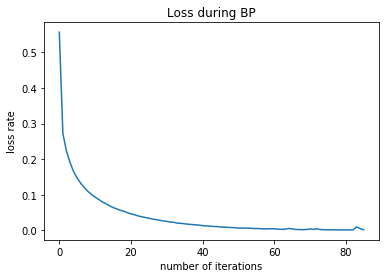

In [0]:
plt.plot(mlp.loss_curve_)
plt.ylabel("loss rate")
plt.xlabel("number of iterations")
plt.title("Loss during BP")
plt.show()


### Predict some tests

Pred:8 / proba_score:0.9083353461747652


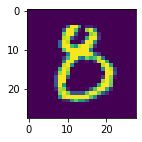

Pred:0 / proba_score:0.9999999999994689


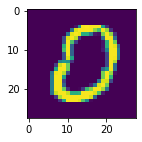

Pred:1 / proba_score:0.9999997414417525


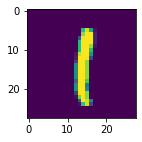

Pred:9 / proba_score:0.999999999932996


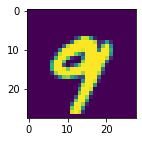

Pred:4 / proba_score:1.0


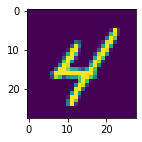

In [0]:
for i in range(5):
    plt.figure(figsize=(3,2))
    idx = np.random.randint(len(X_test))
    y_pred = mlp.predict([X_test[idx]])
    y_proba = np.max(mlp.predict_proba([X_test[idx]]))
    plt.imshow(X_test[idx].reshape(28,28))
    print("Pred:{} / proba_score:{}".format(y_pred[0],y_proba))
    plt.show()

### Compute score

In [0]:
y_pred = mlp.predict(X_test)
precision_score(y_test,y_pred,labels = target_list,average='micro')

0.9714761904761905

### Compute Zero-One Loss 

In [0]:
zero_one_loss(y_test, y_pred)

0.028523809523809507

### Classification Report

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2078
           1       0.98      0.99      0.99      2307
           2       0.97      0.97      0.97      2123
           3       0.96      0.97      0.96      2155
           4       0.98      0.97      0.97      2051
           5       0.97      0.95      0.96      1907
           6       0.97      0.98      0.98      2021
           7       0.97      0.97      0.97      2217
           8       0.96      0.96      0.96      2074
           9       0.96      0.96      0.96      2067

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000



## **2. Precision-Recall Curve & ROC Curve**

In [0]:
X = data
y = label_binarize(target, classes=target_list)
X_train_ovr, X_test_ovr, y_train_ovr ,y_test_ovr = train_test_split(X,y,train_size=0.8)

In [0]:
%%time
clf = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=50,verbose=0))
clf.fit(X_train_ovr, y_train_ovr)

y_score_ovr = clf.predict_proba(X_test_ovr)

CPU times: user 12min 18s, sys: 4min 52s, total: 17min 11s
Wall time: 8min 42s


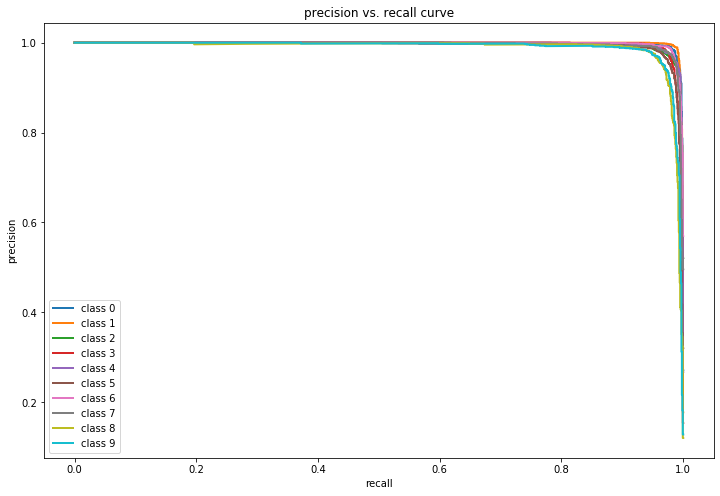

<Figure size 432x288 with 0 Axes>

In [0]:
# precision recall curve
plt.figure(figsize=(12,8))
precision = dict()
recall = dict()
for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(y_test_ovr[:, i],
                                                        y_score_ovr[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
plt.savefig('TP2-precision-recall-curve.png')

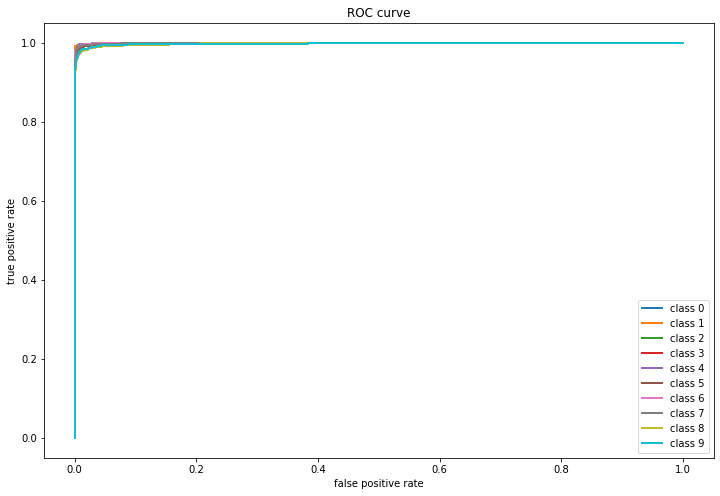

<Figure size 432x288 with 0 Axes>

In [0]:
# roc curve
plt.figure(figsize=(12,8))

fpr = dict()
tpr = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_ovr[:, i],
                                  y_score_ovr[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()
plt.savefig('TP2-ROC-Curve.png')

## **3. Hyperparameter tuning for MLP**

### ***3.0. Number of neurons***

In [13]:
%%time
layers_sizes = []
training_scores, training_loss = [], []
test_scores, test_loss = [], []
training_time = []
nb_neurons = np.arange(10,101,10)
for i in nb_neurons:
  print("Training with 1 hidden layer of {} neurons(s) ...".format(i))
  mlp = MLPClassifier(hidden_layer_sizes=i,verbose=0)
  start = time.clock()
  mlp.fit(X_train,y_train)
  exec_time = time.clock() - start 
  training_time.append(exec_time)
  print("Execution time : ", exec_time)
  training_scores.append(mlp.score(X_train, y_train))
  test_scores.append(mlp.score(X_test, y_test))
  training_loss.append(zero_one_loss(y_train,mlp.predict(X_train)))
  test_loss.append(zero_one_loss(y_test,mlp.predict(X_test)))

Training with 1 hidden layer of 10 neurons(s) ...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Execution time :  81.13662886619568
Training with 1 hidden layer of 20 neurons(s) ...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Execution time :  97.0172815322876
Training with 1 hidden layer of 30 neurons(s) ...
Execution time :  89.9257607460022
Training with 1 hidden layer of 40 neurons(s) ...
Execution time :  76.99641489982605
Training with 1 hidden layer of 50 neurons(s) ...
Execution time :  77.55018210411072
Training with 1 hidden layer of 60 neurons(s) ...
Execution time :  78.38604092597961
Training with 1 hidden layer of 70 neurons(s) ...
Execution time :  70.42761445045471
Training with 1 hidden layer of 80 neurons(s) ...
Execution time :  72.59124612808228
Training with 1 hidden layer of 90 neurons(s) ...
Execution time :  77.96706819534302
Training with 1 hidden layer of 100 neurons(s) ...
Execution time :  71.56363987922668
CPU times: user 18min 51s, sys: 7min 41s, total: 26min 32s
Wall time: 13min 25s


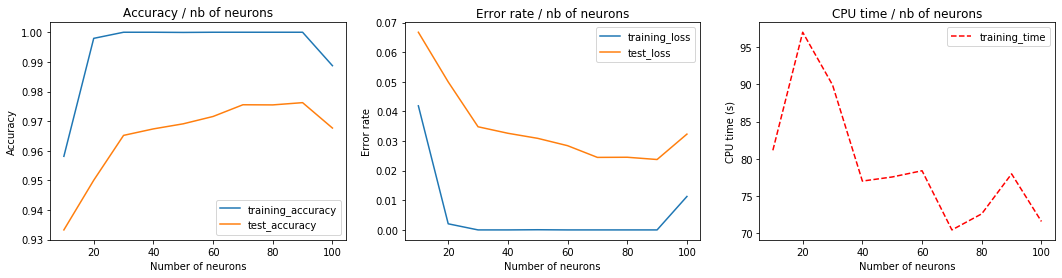

<Figure size 432x288 with 0 Axes>

In [14]:
## PLOT
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(nb_neurons, training_scores, label = "training_accuracy")
plt.plot(nb_neurons, test_scores, label = "test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of neurons")
plt.title("Accuracy / nb of neurons")
plt.legend(loc='best')

plt.subplot(132)
plt.plot(nb_neurons, training_loss, label = "training_loss")
plt.plot(nb_neurons, test_loss, label = "test_loss")
plt.ylabel("Error rate")
plt.xlabel("Number of neurons")
plt.title("Error rate / nb of neurons")
plt.legend(loc='best')

plt.subplot(133)
plt.plot(nb_neurons, training_time,'r--', label = "training_time")
plt.ylabel("CPU time (s)")
plt.xlabel("Number of neurons")
plt.title("CPU time / nb of neurons")
plt.legend(loc='best')

plt.show()

plt.savefig('TP2-acc-loss-vs-nb-neurons.png')

### ***3.1. Number of layers***

In [0]:
%%time
layers_sizes = []
training_scores, training_loss = [], []
test_scores, test_loss = [], []
training_time = []
nb_layers = np.arange(1,10,1)
for i in nb_layers:
  print("Training with {} hidden layer(s) ...".format(i))
  layers_sizes.append(50)
  mlp = MLPClassifier(hidden_layer_sizes=layers_sizes,verbose=0)
  start = time.clock()
  mlp.fit(X_train,y_train)
  exec_time = time.clock() - start 
  training_time.append(exec_time)
  print("Execution time : ", exec_time)
  training_scores.append(mlp.score(X_train, y_train))
  test_scores.append(mlp.score(X_test, y_test))
  training_loss.append(zero_one_loss(y_train,mlp.predict(X_train)))
  test_loss.append(zero_one_loss(y_test,mlp.predict(X_test)))

Training with 1 hidden layer(s) ...
Execution time :  78.68926906585693
Training with 2 hidden layer(s) ...
Execution time :  51.40885281562805
Training with 3 hidden layer(s) ...
Execution time :  56.99508333206177
Training with 4 hidden layer(s) ...
Execution time :  76.26517677307129
Training with 5 hidden layer(s) ...
Execution time :  48.9894585609436
Training with 6 hidden layer(s) ...
Execution time :  63.811272621154785
Training with 7 hidden layer(s) ...
Execution time :  79.28539156913757
Training with 8 hidden layer(s) ...
Execution time :  161.8321554660797
Training with 9 hidden layer(s) ...
Execution time :  111.6047043800354
CPU times: user 17min 20s, sys: 7min 10s, total: 24min 30s
Wall time: 12min 23s


Best nb of layers with highest test score:  3
Best nb of layers with fastet training time:  7


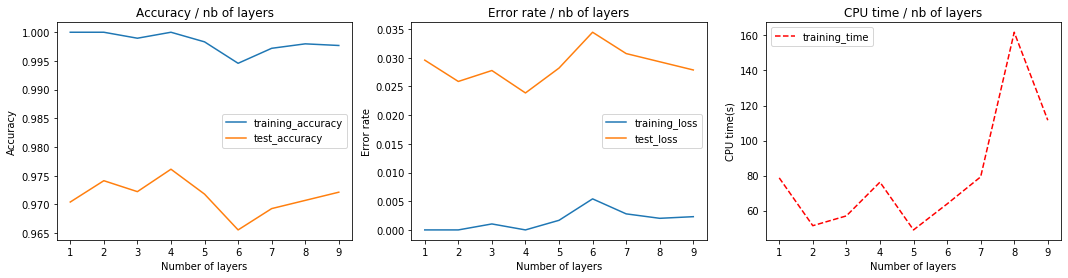

<Figure size 432x288 with 0 Axes>

In [0]:
print("Best nb of layers with highest test score: ",np.argmax(test_scores))
print("Best nb of layers with fastet training time: ",np.argmax(training_time))

## PLOT 
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(nb_layers, training_scores, label = "training_accuracy")
plt.plot(nb_layers, test_scores, label = "test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of layers")
plt.title("Accuracy / nb of layers")
plt.legend(loc='best')

plt.subplot(132)
plt.plot(nb_layers, training_loss, label = "training_loss")
plt.plot(nb_layers, test_loss, label = "test_loss")
plt.ylabel("Error rate")
plt.xlabel("Number of layers")
plt.title("Error rate / nb of layers")
plt.legend(loc='best')

plt.subplot(133)
plt.plot(nb_layers, training_time,'r--', label = "training_time")
plt.ylabel("CPU time(s)")
plt.xlabel("Number of layers")
plt.title("CPU time / nb of layers")
plt.legend(loc='best')

plt.show()

plt.savefig('TP2-acc-loss-vs-nb-layers.png')

### ***3.2. Optimization algos : L-BFGS, SGD, Adam***

Because L-BFGS is not a stochastic algorithm which minimize loss function over iteration, we plot two graphs which show the evolution of only SGD vs. Adam algorithms. Besides we also try to test the performance of all three algos in case of different sizes of dataset.

#### ***3.2.1. Accuracy evolution over epoch (SGD vs. Adam)***


In [0]:
def mini_batch_learning(optimi_algo='adam',alpha=1e-4,activation='relu') : 

    mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, 
                        alpha=alpha, 
                        activation = activation,
                        solver=optimi_algo, 
                        verbose=0, tol=1e-8, random_state=1,
                        learning_rate_init=.01)

    """ 
    Mini-batch learning with a specific optimisation algo (i.e. 'sgd' or 'adam')
    This function does not work with 'lbfgs' algo because it is not a stochastic algo
    """
    N_TRAIN_SAMPLES = X_train.shape[0]
    print("Number of training samples : ",N_TRAIN_SAMPLES)
    N_EPOCHS = 31
    N_BATCH = 128
    N_CLASSES = np.unique(y_train)

    scores_train = []
    scores_test = []

    # EPOCH
    epoch = 0
    while epoch < N_EPOCHS:
        if (epoch) % 10 == 0:
            print('epoch: ', epoch)
        # SHUFFLING
        random_perm = np.random.permutation(X_train.shape[0])
        mini_batch_index = 0
        while True:
            # MINI-BATCH
            indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
            mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

        # SCORE TRAIN
        scores_train.append(mlp.score(X_train, y_train))

        # SCORE TEST
        scores_test.append(mlp.score(X_test, y_test))

        epoch += 1
    return scores_train, scores_test

* **Launch mini-batch learning with different optimisation algorithms**

In [0]:
%%time
adam_scores_train, adam_scores_test = mini_batch_learning(optimi_algo='adam')
# plt.plot(adam_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(adam_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.legend(loc='upper left')
# plt.show()
# plt.savefig("TP2-acc-vs-nb-epoch-adam.png")

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 26s, sys: 1min 17s, total: 3min 43s
Wall time: 1min 55s


In [0]:
%%time
sgd_scores_train, sgd_scores_test = mini_batch_learning(optimi_algo='sgd')
# plt.plot(sgd_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(sgd_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.legend(loc='upper left')
# plt.show()
# plt.savefig("TP2-acc-vs-nb-epoch-lbfgs.png")

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 20s, sys: 1min 11s, total: 3min 31s
Wall time: 1min 50s


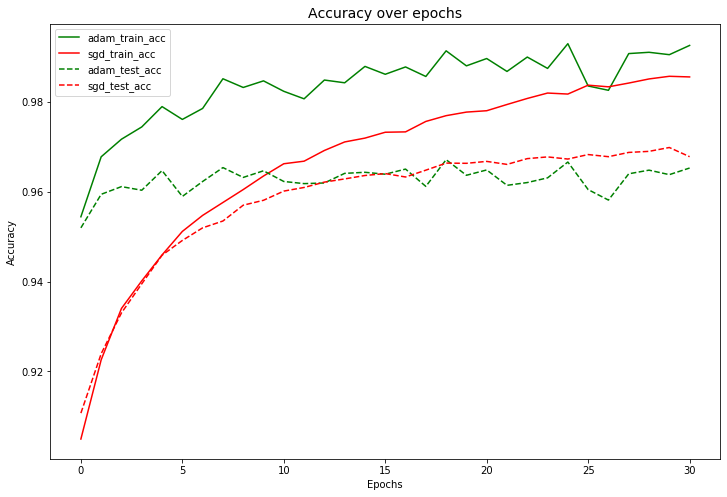

<Figure size 432x288 with 0 Axes>

In [0]:
## PLOT
plt.figure(figsize=(12,8))

plt.plot(adam_scores_train, 'g', label='adam_train_acc')
plt.plot(sgd_scores_train, 'r', label='sgd_train_acc')
plt.plot(adam_scores_test, 'g--', label='adam_test_acc')
plt.plot(sgd_scores_test, 'r--', label='sgd_test_acc')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()
plt.savefig("TP2-acc-vs-optimization-algo.png")

#### ***3.2.2. Loss evolution over iteration (SGD vs. Adam)***

In [0]:
%%time 
print("Starting with adam solver...")
adam_mlp = MLPClassifier(hidden_layer_sizes=50,solver='adam',max_iter=50) 
adam_mlp.fit(X_train,y_train)
print("Starting with sgd solver...")
sgd_mlp = MLPClassifier(hidden_layer_sizes=50,solver='sgd',max_iter=50) 
sgd_mlp.fit(X_train,y_train)

Starting with adam solver...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Starting with sgd solver...
CPU times: user 2min 21s, sys: 55.7 s, total: 3min 16s
Wall time: 1min 40s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


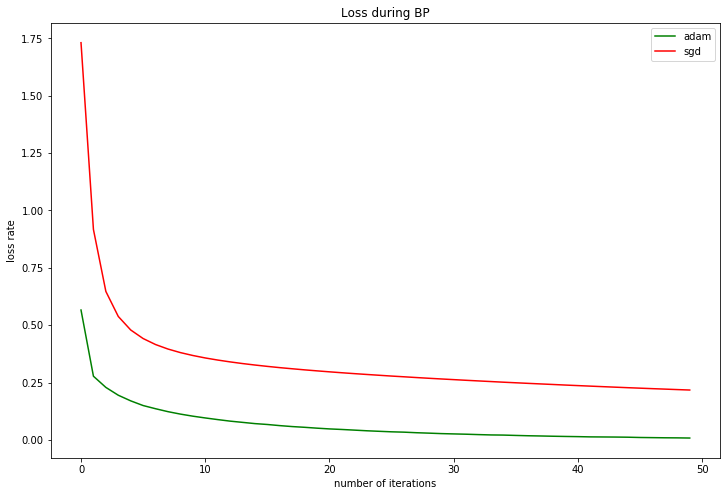

<Figure size 432x288 with 0 Axes>

In [0]:
## PLOT
plt.figure(figsize=(12,8))
plt.plot(adam_mlp.loss_curve_,'g',label='adam')
plt.plot(sgd_mlp.loss_curve_,'r',label='sgd')
plt.ylabel("loss rate")
plt.xlabel("number of iterations")
plt.title("Loss during BP")
plt.legend(loc='best')
plt.show()
plt.savefig("TP2-loss-solver.png")

#### ***3.2.3. L-BFGS performs better for small dataset ?***

In [0]:
# %%time
# layers_sizes = []
# training_scores = []
# test_scores = []
# data_size = np.array([1000,2000,4000,5000,10000,20000,40000,60000])
# for size in data_size:
#   print("Size of data : {} samples ...".format(size))
#   # take a batch of dataset
#   indexes = random.sample(range(70000),size)
#   X2 = mnist.data[indexes]
#   y2 = mnist.target[indexes]
#   X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,train_size =0.8)

#   mlp_adam = MLPClassifier(hidden_layer_sizes=50,solver='adam',verbose=0)
#   mlp_adam.fit(X2_train,y2_train)

#   mlp_sgd = MLPClassifier(hidden_layer_sizes=50,solver='sgd',verbose=0)
#   mlp_sgd.fit(X2_train,y2_train)
  
#   mlp_lbfgs = MLPClassifier(hidden_layer_sizes=50,solver='lbfgs',verbose=0)
#   mlp_lbfgs.fit(X2_train,y2_train)

#   print("Computing scores...")
#   training_scores.append([mlp_adam.score(X2_train, y2_train),mlp_sgd.score(X2_train, y2_train),mlp_lbfgs.score(X2_train, y2_train)])
#   test_scores.append([mlp_adam.score(X2_test, y2_test),mlp_sgd.score(X2_test, y2_test),mlp_lbfgs.score(X2_test, y2_test)])

# training_scores = np.array(training_scores).transpose()
# test_scores = np.array(test_scores).transpose()


In [0]:
## PLOT

# plt.figure(figsize=(12,8))

# plt.plot(data_size,training_scores[0], 'g', label='adam_train_acc')
# plt.plot(data_size,training_scores[1], 'r', label='sgd_train_acc')
# plt.plot(data_size,training_scores[2], 'b', label='lbfgs_train_acc')

# plt.plot(data_size,test_scores[0], 'g--', label='adam_test_acc')
# plt.plot(data_size,test_scores[1], 'r--', label='sgd_test_acc')
# plt.plot(data_size,test_scores[2], 'b--', label='lbfgs_test_acc')

# plt.title("Accuracy / size of dataset", fontsize=14)
# plt.xlabel('Size of dataset')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')

# plt.show()
# plt.savefig("TP2-optimization-algo-vs-datasize.png")

### ***3.3. Activation function : identity, logsitic, tanh,relu***

#### ***3.3.1. Accuracy over epoch***

Launch mini-batch learning with different activation functions

In [0]:
%%time
iden_scores_train, iden_scores_test = mini_batch_learning(optimi_algo='adam',activation='identity')
# plt.plot(iden_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(iden_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='upper left')
# plt.show()

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 21s, sys: 1min 14s, total: 3min 35s
Wall time: 1min 52s


In [0]:
%%time
log_scores_train, log_scores_test = mini_batch_learning(optimi_algo='adam',activation='logistic')
# plt.plot(log_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(log_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='upper left')
# plt.show()

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 30s, sys: 1min 20s, total: 3min 50s
Wall time: 1min 59s


In [0]:
%%time
tanh_scores_train, tanh_scores_test = mini_batch_learning(optimi_algo='adam',activation='tanh')
# plt.plot(tanh_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(tanh_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='upper left')
# plt.show()

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 32s, sys: 1min 21s, total: 3min 53s
Wall time: 2min 1s


In [0]:
%%time
relu_scores_train, relu_scores_test = mini_batch_learning(optimi_algo='adam',activation='relu')
# plt.plot(relu_scores_train, color='green', alpha=0.8, label='Train')
# plt.plot(relu_scores_test, color='red', alpha=0.8, label='Test')
# plt.title("Accuracy over epochs", fontsize=14)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='upper left')
# plt.show()

Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
CPU times: user 2min 26s, sys: 1min 16s, total: 3min 43s
Wall time: 1min 55s


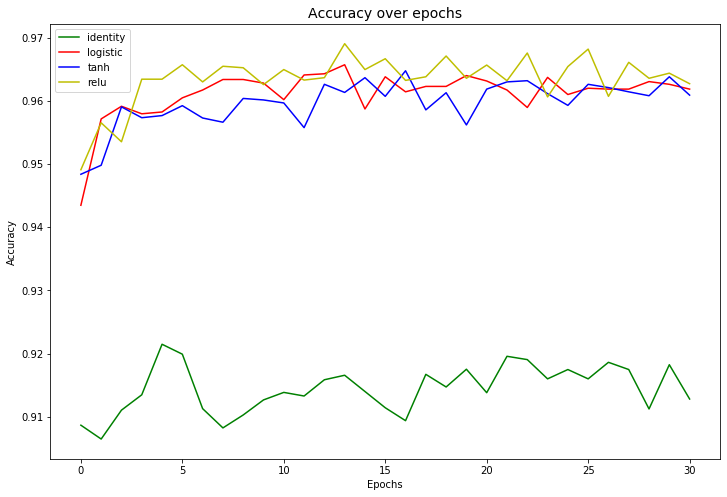

<Figure size 432x288 with 0 Axes>

In [0]:
## PLOT
plt.figure(figsize=(12,8))

plt.plot(iden_scores_test, 'g', label='identity')
plt.plot(log_scores_test, 'r', label='logistic')
plt.plot(tanh_scores_test, 'b', label='tanh')
plt.plot(relu_scores_test, 'y', label='relu')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()
plt.savefig("TP2-acc-vs-activation.png")

#### ***3.3.2. Loss over iteration***

In [0]:
%%time 
print("Starting with identity activation...")
iden_mlp = MLPClassifier(hidden_layer_sizes=50,activation='identity',max_iter=50) 
iden_mlp.fit(X_train,y_train)
print("Starting with logistic activation...")
log_mlp = MLPClassifier(hidden_layer_sizes=50,activation='logistic',max_iter=50) 
log_mlp.fit(X_train,y_train)
print("Starting with tanh activation...")
tanh_mlp = MLPClassifier(hidden_layer_sizes=50,activation='tanh',max_iter=50) 
tanh_mlp.fit(X_train,y_train)
print("Starting with relu activation...")
relu_mlp = MLPClassifier(hidden_layer_sizes=50,activation='relu',max_iter=50) 
relu_mlp.fit(X_train,y_train)

Starting with identity activation...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Starting with logistic activation...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Starting with tanh activation...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Starting with relu activation...
CPU times: user 4min 59s, sys: 2min 6s, total: 7min 5s
Wall time: 3min 36s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


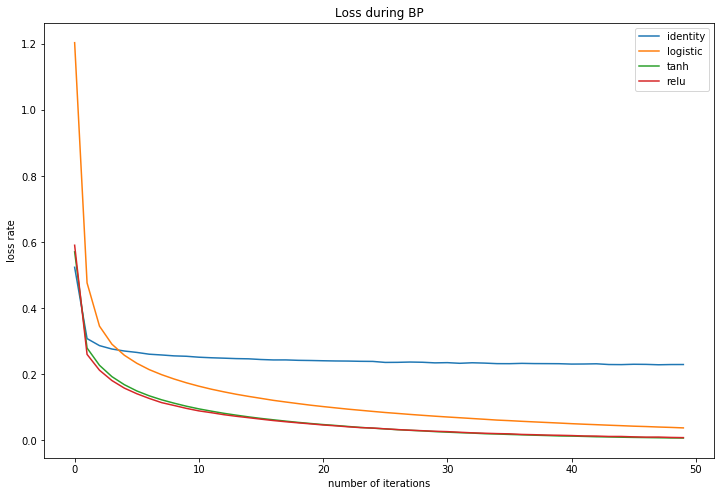

<Figure size 432x288 with 0 Axes>

In [0]:
## PLOT
plt.figure(figsize=(12,8))
plt.plot(iden_mlp.loss_curve_,label='identity')
plt.plot(log_mlp.loss_curve_,label='logistic')
plt.plot(tanh_mlp.loss_curve_,label='tanh')
plt.plot(relu_mlp.loss_curve_,label='relu')
plt.ylabel("loss rate")
plt.xlabel("number of iterations")
plt.title("Loss during BP")
plt.legend(loc='best')
plt.show()
plt.savefig("TP2-loss-activation.png")

### ***3.4. Parameter alpha of L2 Regularization***

#### ***3.4.1. Accuracy over epoch***

Training with alpha = 0.1...
Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
Training with alpha = 0.01...
Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
Training with alpha = 0.001...
Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
Training with alpha = 0.0001...
Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30
Training with alpha = 1e-05...
Number of training samples :  49000
epoch:  0
epoch:  10
epoch:  20
epoch:  30


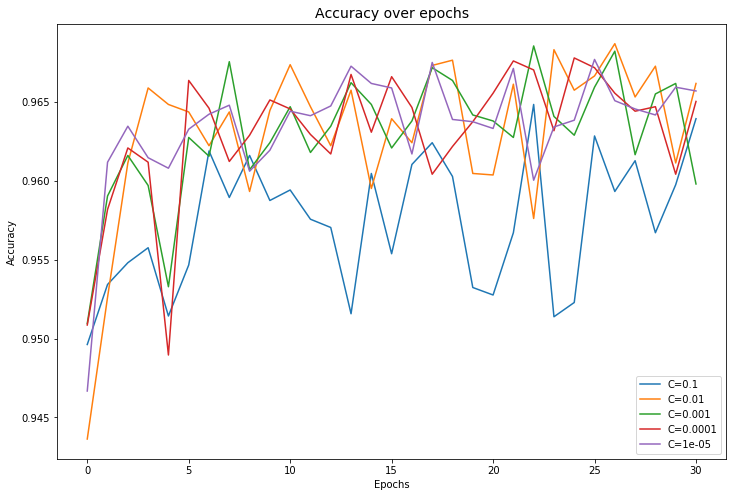

CPU times: user 12min 11s, sys: 6min 27s, total: 18min 39s
Wall time: 9min 41s


<Figure size 432x288 with 0 Axes>

In [0]:
%%time
plt.figure(figsize=(12,8))
scores_per_C = []
for i in range(5):
    alpha = round(0.1 ** (i+1),6)
    print("Training with alpha = {}...".format(alpha))
    scores_train, scores_test = mini_batch_learning(optimi_algo='adam',activation='relu',alpha=alpha)
    scores_per_C.append(scores_test)
    plt.plot(scores_test, label='C={}'.format(alpha))

plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()
plt.savefig("TP2-acc-per-C.png")

#### ***3.4.2. Loss over iteration***

Training with alpha = 0.1...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training with alpha = 0.01...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training with alpha = 0.001...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training with alpha = 0.0001...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training with alpha = 1e-05...


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


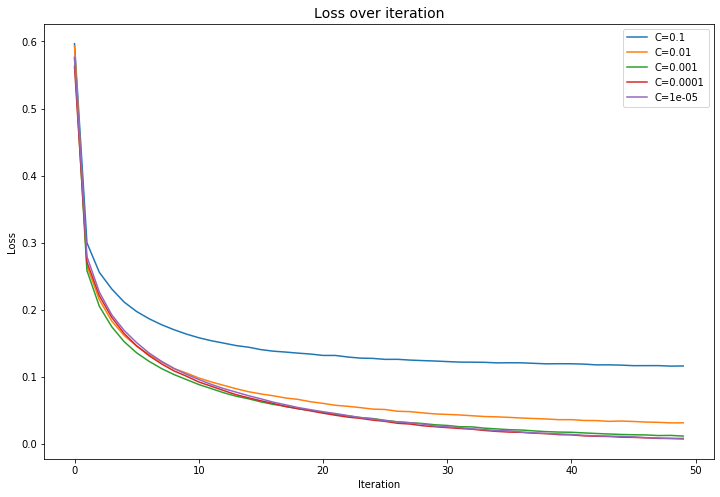

CPU times: user 6min 12s, sys: 2min 36s, total: 8min 48s
Wall time: 4min 28s


<Figure size 432x288 with 0 Axes>

In [0]:
%%time 
plt.figure(figsize=(12,8))
scores_per_C = []
for i in range(5):
    alpha = round(0.1 ** (i+1),6)
    print("Training with alpha = {}...".format(alpha))
    mlp = MLPClassifier(hidden_layer_sizes=50, max_iter=50,alpha=alpha)
    mlp.fit(X_train,y_train)
    plt.plot(mlp.loss_curve_,label='C={}'.format(alpha))

plt.title("Loss over iteration", fontsize=14)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()
plt.savefig("TP2-losss-per-C.png")

##  **4. Best model ?**

**From above explorations :**

* n_layers = 3
* solver = 'adam'
* activation = 'relu'
* C = 1e-5

### **Hyper-parameter optimization with GridSearchCV**

**Attention :** This block will take a long time to finish....

In [0]:
# %%time
# # Prepare again dataset
# X_train, X_test, y_train, y_test = train_test_split(mnist.data,mnist.target,train_size =0.8)

# ## 0-1 Scaling
# X_train = X_train / 255. 
# X_test = X_test / 255. 

# ## Choose a classifier
# mlp = MLPClassifier(max_iter=100)

# ## Define a hyper-parameter space to search
# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }

# ## Run the search, using cross-validation with 3-fold
# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)

# ## Print best parameter set 
# print('Best parameters found:\n', clf.best_params_)

# ## Print all results 
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

---